<center><font size="5"><b>Causal AI: <br> Causal Impact of Player Substitutions on Soccer Team Performance</b></font></center>

In [1]:
import pathlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
import seaborn as sns

from causalai.simulation__ import simulate_matches
from causalai.auxiliaries import *


import dowhy
import networkx as nx
import pygraphviz
# import pgmpy

from pgmpy.models import DiscreteBayesianNetwork
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from pgmpy.inference import CausalInference

import arviz as az
import pymc as pm

In [2]:
plt.style.use("seaborn-v0_8")
sns.set_palette("husl")
seed = sum(map(ord, "eda-simulation"))
rng = np.random.default_rng(seed)

In [3]:
# =================================== USER INTERACTION -- Global Parameters =================================== #

# -------------------------------- Data -------------------------------- #

# --- How many matches do you want to Simulate? [None --> no simulation, but instead data loading; int --> number of matches]
N_MATCHES = 10000

# --- In case you already have some data, and don't want simulated data, insert the file-path below: [None; str]
CSV_PATH = None 

# --- Directory to save the output: 
OUTPUT_DIR = pathlib.Path("eda_outputs")



# -------------------------------- Model -------------------------------- #

# --- Select the outcomes (Y) that you want to analyze the causal drivers of: ['shots','goals','passes']
OUTCOMES = ["shots","goals","passes"]


# -------------------------------- Figures -------------------------------- #

# --- Want to save the figures? [True; False]
SAVE_FIG = False

# =================================== USER INTERACTION -- Global Parameters =================================== #

<br>

## 00. &emsp; Data Loading / Simulation

In [4]:
# =================================== 00.1 Load the Data =================================== #

if N_MATCHES:
    df = simulate_matches(n_matches=N_MATCHES, seed=seed)
else:
    if CSV_PATH:
        df = pd.read_csv(CSV_PATH)
    else:
        df = pd.DataFrame()
        print('\n[ERROR]: You didn\'t neither specify \'N_MATCHES\' nor \'CSV_PATH\' --> no data loaded!')


print(f"\nDataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print("\n")
df.head()

[-4.67815346  0.14354887  5.08708998]

Dataset shape: (10000, 17)
Columns: ['off_old', 'def_old', 'strength_diff', 'strength_quartile', 'score_diff', 'sub', 'off_new', 'def_new', 'fresh_legs_boost', 'tactical_factor', 'shots', 'goals', 'passes', 'passes_counterfactual', 'ite_passes_expected', 'ite_passes_observed', 'ate_passes_expected']




,off_old,def_old,strength_diff,strength_quartile,score_diff,sub,off_new,def_new,fresh_legs_boost,tactical_factor,shots,goals,passes,passes_counterfactual,ite_passes_expected,ite_passes_observed,ate_passes_expected
0,59.829088,50.311367,9.517721,Q4,1,0,59.829088,50.311367,1.000000,1.000000,8,3,37,57,18.924717,20,8.407981
1,66.932724,55.248509,11.684215,Q4,1,0,66.932724,55.248509,1.000000,1.000000,8,1,52,51,0.598702,-1,8.407981
2,45.705586,52.293501,-6.587915,Q1,0,1,53.513528,50.458338,1.157717,1.118443,4,0,42,36,-1.146222,6,8.407981
3,33.402367,39.559093,-6.156727,Q1,0,1,40.485343,38.310803,1.654761,1.010980,5,2,30,28,3.202184,2,8.407981
4,47.139818,49.026986,-1.887168,Q2,-1,0,47.139818,49.026986,1.000000,1.000000,7,0,31,29,-1.317691,-2,8.407981


<br>

## 1. &emsp; Descriptive Statistics

In [5]:
# =================================== 1.1 Some Preliminary Summary Statistics =================================== #

df.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
off_old,10000.0,55.07,10.10,13.41,48.09,54.96,61.91,91.91
def_old,10000.0,54.94,7.13,28.86,50.10,54.92,59.65,83.58
strength_diff,10000.0,0.13,7.19,-30.96,-4.68,0.14,5.09,26.02
score_diff,10000.0,0.20,0.83,-3.00,0.00,0.00,1.00,3.00
sub,10000.0,0.50,0.50,0.00,0.00,1.00,1.00,1.00
off_new,10000.0,57.53,9.96,20.00,50.78,57.46,64.24,90.00
def_new,10000.0,53.98,7.97,24.94,48.48,53.93,59.37,83.58
fresh_legs_boost,10000.0,1.11,0.22,0.80,1.00,1.00,1.20,1.80
tactical_factor,10000.0,1.06,0.13,0.90,1.00,1.00,1.10,1.40
shots,10000.0,6.85,3.37,0.00,4.00,6.00,9.00,26.00


In [6]:
# =================================== 1.2 Number of Games with Substitutions made =================================== #


print("\nTreatment Distribution:")
print(f"  Substitution rate: {df['sub'].mean():.3f} ({df['sub'].sum()}/{len(df)})")
print(f"  No substitution: {len(df[df['sub'] == 0])} ({len(df[df['sub'] == 0]) / len(df):.1%})")
print(f"  Substitution: {len(df[df['sub'] == 1])} ({len(df[df['sub'] == 1]) / len(df):.1%})")


Treatment Distribution:
  Substitution rate: 0.504 (5039/10000)
  No substitution: 4961 (49.6%)
  Substitution: 5039 (50.4%)


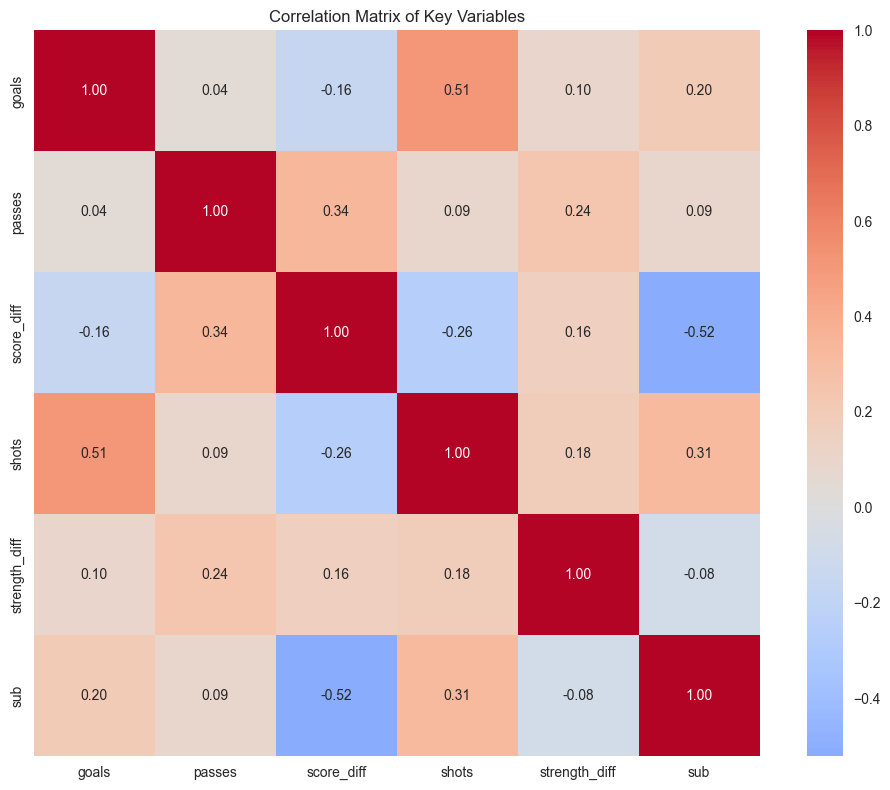

In [7]:
# =================================== 1.3 Inspect Correlations =================================== #


# --- Variables to inspect:
key_vars = list(np.unique(["sub","score_diff","strength_diff"] + OUTCOMES))

# --- Correlation matrix of key variables:
correlation_matrix = df[key_vars].corr()

# --- Plot the Matrix:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", center=0, square=True, fmt=".2f")
plt.title("Correlation Matrix of Key Variables")
plt.tight_layout()
if SAVE_FIG:
    plt.savefig(OUTPUT_DIR / "correlation_matrix.png", dpi=300, bbox_inches="tight")
    print("\nCorrelation matrix saved to output directory.")
plt.show()



In [8]:
# ================================== 1.4 Zooming in on Score Differential ================================== #

print(f"\nCorrelation between Score Differential & Treatment Assignment: {df["score_diff"].corr(df["sub"]):.3f}")

print("\nCorrelation between Score Differential & Outcomes:\n")
for outcome in OUTCOMES:
    corr = df["score_diff"].corr(df[outcome])
    print(f"{outcome}: {corr:.3f}")


Correlation between Score Differential & Treatment Assignment: -0.522

Correlation between Score Differential & Outcomes:

shots: -0.259
goals: -0.159
passes: 0.337


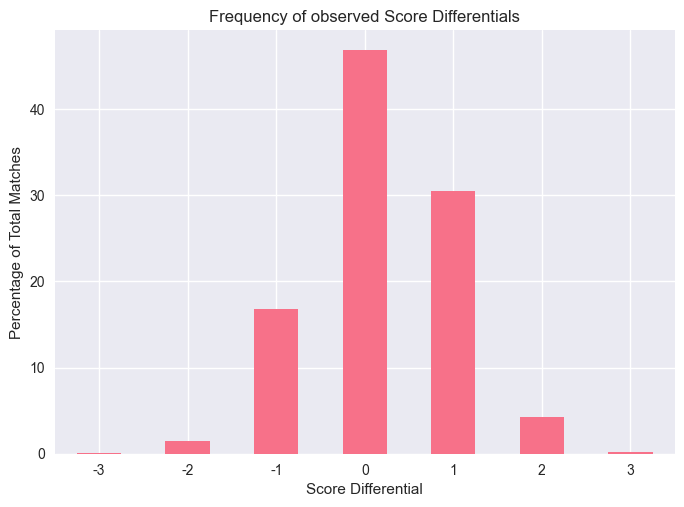

In [9]:
# ================================== 1.5 Distribution of Score Differentials ================================== #


(df.groupby("score_diff")["sub"].count() / df.shape[0] * 100).plot.bar(
    rot=0, ylabel="Percentage of Total Matches", title="Frequency of observed Score Differentials", xlabel="Score Differential"
);

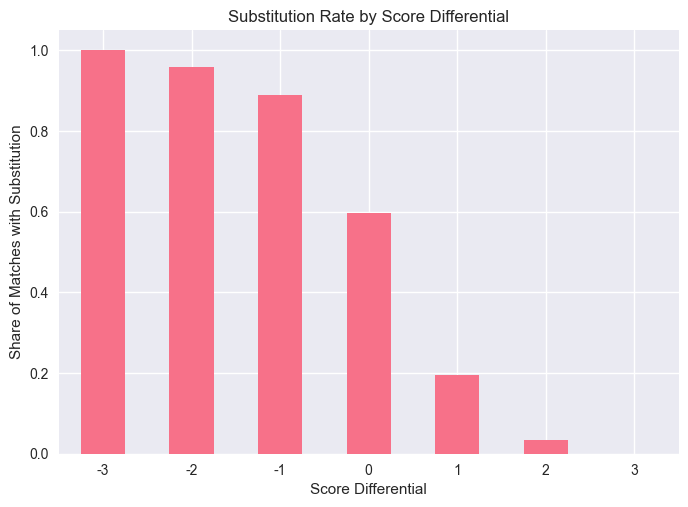

In [10]:
# ================================== 1.6 How does Substitution vary with Score Differential? ================================== #


(df.groupby("score_diff")["sub"].sum() / df.groupby("score_diff")["sub"].count()).plot.bar(
    rot=0, ylabel="Share of Matches with Substitution", title="Substitution Rate by Score Differential", xlabel="Score Differential"
);

<br>

## 2. &emsp; Treatment Effect Heterogeneity


HETEROGENEOUS TREATMENT EFFECTS ANALYSIS --- OUTCOME: Passes
1. Treatment Effects by Score Differential:
  Score -3: ATE = nan (Treated: 21.80, Control: nan)
  Score -2: ATE = 5.300 (Treated: 27.30, Control: 22.00)
  Score -1: ATE = 8.108 (Treated: 38.54, Control: 30.43)
  Score 0: ATE = 9.394 (Treated: 47.42, Control: 38.03)
  Score 1: ATE = 9.977 (Treated: 55.56, Control: 45.59)
  Score 2: ATE = 11.122 (Treated: 64.33, Control: 53.21)
  Score 3: ATE = nan (Treated: nan, Control: 65.12)

2. Treatment Effects by Initial Team Strength Differential
 (Lower Quartiles --> Offense Weaker than in Higher Quartiles realtive to Defense):
  Q1: ATE = 1.285 (Treated: 40.74, Control: 39.45)
  Q2: ATE = 2.854 (Treated: 44.33, Control: 41.47)
  Q3: ATE = 3.677 (Treated: 46.87, Control: 43.19)
  Q4: ATE = 3.574 (Treated: 49.98, Control: 46.41)


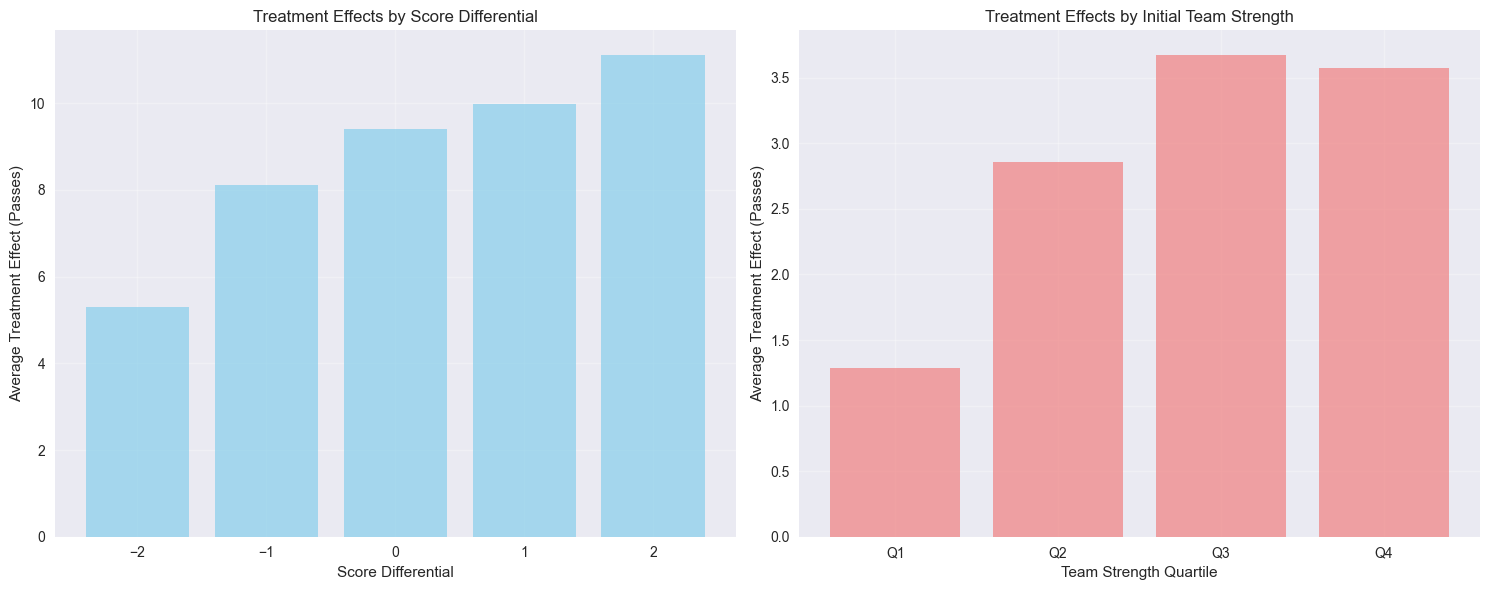

In [11]:
# ================================== USER INTERACTION ================================== #

# --- Which is the outcome (Y) you are interested in to analyze?
outcome_label = "passes"

# ================================== USER INTERACTION ================================== #


analyze_heterogeneous_effects(df,outcome_label)

<br>

## 3. &emsp; Substitution Effect Analysis

Compare a naïve estimates of substitution impact on $Y$ vs. an estimate when *conditioning* on a certain variabel (e.g. `score_diff`). This shall reveal which variables to look out for when estimating the causal effect of `sub` on $Y$.

Naïve difference in Passes (Sub - No Sub): 2.402
Adjusted difference in Passes (Sub - No Sub): 8.780
Difference between naïve and adjusted: -6.378


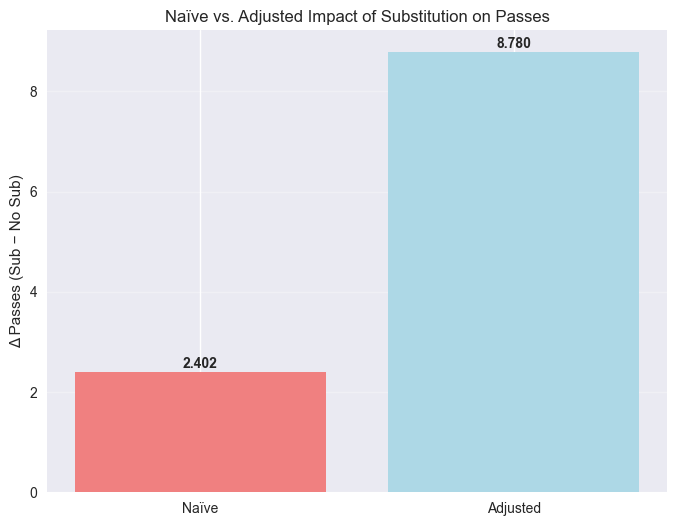

In [12]:
# --- Analyze substitution effects
plot_naive_vs_adjusted(df, OUTPUT_DIR, outcome_label,var_confounder='score_diff')


<br>

## 2. &emsp; Propensity Score Matching -- A Precurser to Causal Inference

The propensity score estimates the probability that a team receives a substitution given their observed characteristics.

This means: "What is the probability that a team makes a substitution, given their offensive strength, defensive strength, and current score differential?"

#### Estimation:
- Input Variables: `off_old`, `def_old`, `score_diff` (the confounders)
- Model: Logistic regression trained to predict substitution decisions
- Output: A probability between 0 and 1 for each team

#### What Insights does it give us?

1. **Treatment Assignment Mechanism**

&emsp;&emsp; The propensity score reveals when teams are most likely to make substitutions:
- Teams trailing (negative score_diff) → Higher substitution probability
- Teams leading (positive score_diff) → Lower substitution probability
- Stronger teams might have different substitution patterns

2. **Confounder Control**
 
&emsp;&emsp; The propensity score captures all the information about confounders that affect both:
- Treatment assignment (when substitutions happen)
- Outcomes (match performance)

3. **Causal Assumption Validation**
   
&emsp;&emsp; The code checks for overlap in propensity scores: This validates the positivity assumption, i.e. teams with similar characteristics could potentially be in either treatment group.

#### In our Soccer Context:

- High propensity score (e.g., 0.8): Teams that are very likely to substitute (probably losing, weaker teams)
- Low propensity score (e.g., 0.2): Teams that rarely substitute (probably winning, stronger teams)
- Medium propensity score (e.g., 0.5): Teams where substitution is uncertain

This will help us understand the selection bias in our data and is crucial for implementing methods like propensity score matching or weighting to get unbiased causal estimates of substitution effects.

<br>

In [13]:
# ================================== 2.1 Propensity to Substitute (i.e. bring in fresh Legs!) ================================== #

# --- Variables to affect a substitution decision:
X_propensity = df[["off_old", "def_old", "score_diff"]]

# --- Scale the Variables:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_propensity)


# --- Estimation via Logistic Regression:
mod__LR = LogisticRegression(random_state=seed).fit(X_scaled, df["sub"])
df["propensity_score"] = mod__LR.predict_proba(X_scaled)[:, 1]

print(
    f"  Propensity score range: [{df['propensity_score'].min():.3f}, {df['propensity_score'].max():.3f}]"
)
print(f"  Mean propensity (treated): {df[df['sub'] == 1]['propensity_score'].mean():.3f}")
print(f"  Mean propensity (control): {df[df['sub'] == 0]['propensity_score'].mean():.3f}")

  Propensity score range: [0.007, 0.997]
  Mean propensity (treated): 0.644
  Mean propensity (control): 0.361


<br>

Is there a clear *distinction* in the probability to substitute (i.e. the propensity scors) between the treated group and the non-treated group? Or is there an *overlap* instead?


In [14]:
# ================================== 2.2 Overlap?  ================================== #

treated_ps = df[df["sub"] == 1]["propensity_score"]
control_ps = df[df["sub"] == 0]["propensity_score"]
overlap_exists = control_ps.min() < treated_ps.max() and treated_ps.min() < control_ps.max()
print(f"  Propensity score overlap: {'✓' if overlap_exists else '✗'}")

  Propensity score overlap: ✓


In [15]:
# ================================== 2.3 Is there a bias in the Covariates between groups?  ================================== #

check_balance(df,varX=X_propensity.columns.to_list())

  off_old:
    Treated mean: 53.248
    Control mean: 53.230
    Standardized difference: 0.002
    Balance: ✓
  def_old:
    Treated mean: 53.687
    Control mean: 53.663
    Standardized difference: 0.003
    Balance: ✓
  score_diff:
    Treated mean: -0.230
    Control mean: -0.229
    Standardized difference: -0.001
    Balance: ✓


<br>

## 3. &emsp; Identifying Causal Relationships: The Causal Graph

We now define the causal relationships between our features ($X$) and the target/outcome ($Y$), as well as, among features. Here, the *domain knowledge* of the researcher can be helpful ...

<br>

In [16]:
# ================================== USER INTERACTION ================================== #

# --- Which is the outcome (Y) you are interested in to analyze?
outcome_label = "passes"

# --- Set the bivariate DIRECTED edges of the relationships within the graph, i.e. define the DAG:
edges = [
    # Baseline team characteristics
    # Confounders affecting both treatment and outcomes
    ("off_old", "score_diff"),
    ("off_old", "def_old"),
    ("off_old", "off_new"),
    ("def_old", "def_new"),
    ("def_old", "score_diff"),
    ("score_diff", "sub"),  # Score affects substitution decision
    # Treatment effects
    ("sub", "off_new"),
    ("sub", "def_new"),
    # Outcome generation
    ("off_new", outcome_label),
    ("def_new", outcome_label),
    # Score differential affects outcomes (confounder)
    ("score_diff", outcome_label),
]

# ================================== USER INTERACTION ================================== #

In [17]:
# ================================== 3.1 Create the DAG ================================== #

dag = DiscreteBayesianNetwork(edges)

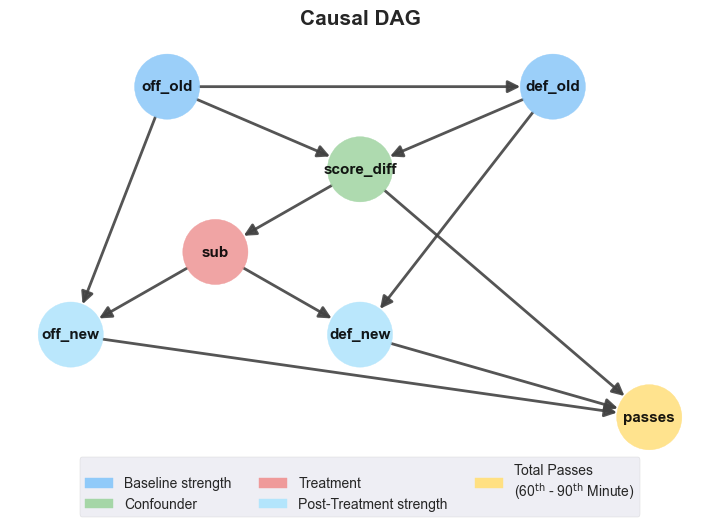

In [18]:
# ================================== 3.2 Plot the DAG ================================== #

"""
    The DAG below is based on the DEFAULT exercise of analyzing the causal effect of SUBSTITUTION on PASSES!
"""


# --- Manual layout for clarity (top-down)
pos = {
    "off_old": (2, 8),
    "def_old": (6, 8),
    "score_diff": (4, 6.5),
    "sub": (2.5, 5),
    "off_new": (1, 3.5),
    "def_new": (4, 3.5),
    outcome_label: (7, 2),
}

# --- Node color mapping:
node_colors = {
    "off_old": "#90caf9",  # blue: baseline
    "def_old": "#90caf9",  # baseline
    "score_diff": "#a5d6a7",  # green: confounder
    "sub": "#ef9a9a",  # red: treatment
    "off_new": "#b3e5fc",  # cyan: post-treat
    "def_new": "#b3e5fc",  # post-treat
    outcome_label: "#ffe082",  # orange: outcome
}

# --- Draw the DAG:
plt.figure(figsize=(7, 4))
nx.draw(
    dag,
    pos,
    with_labels=True,
    node_color=[node_colors[n] for n in dag.nodes()],
    node_size=2200,
    font_size=11,
    font_weight="bold",
    arrows=True,
    arrowsize=18,
    edge_color="#424242",
    width=2,
    alpha=0.9,
)

# --- Some Cosmetics:
legend_elements = [
    mpatches.Patch(color="#90caf9", label="Baseline strength"),
    mpatches.Patch(color="#a5d6a7", label="Confounder"),
    mpatches.Patch(color="#ef9a9a", label="Treatment"),
    mpatches.Patch(color="#b3e5fc", label="Post-Treatment strength"),
    mpatches.Patch(color="#ffe082", label="Total Passes\n(60$^{\\text{th}}$ - 90$^{\\text{th}}$ Minute)"),
]
plt.legend(
    handles=legend_elements, loc="lower center", bbox_to_anchor=(0.5, -0.18), ncol=3, frameon=True
)
plt.title("Causal DAG", fontsize=15, fontweight="bold", pad=20)
plt.axis("off");

<br>

### 3.1 &emsp; Identifying the Set of *d-Separations* in the DAG

In the DAG above we see that there is no direct relationship between our variable of interest (`sub`) and our outcome variable (`passes`).

For example, `sub` affects `passes` only through `def_new`, the strength of the leading team after having made a substitution, and `off_new`, the strength of the trailing team after having made a substitution,

We now want to identify all variables that could **potentially** block (i.e.: stand in the way of) `sub` to have an effect on `passes`. This is what is called: identifying the *d-separating sets*.

In [19]:
# ============================== 3.1 Minimal d-Separating Set ============================== #

# (sub ⟂ outcome | def_new, off_new, score_diff)
# --- Which are the Variables that could potentially "block" the shortest paths between `sub` and Y?
dag.minimal_dseparator(start="sub", end=outcome_label)


{'def_new', 'off_new', 'score_diff'}

<br>

### 3.2 &emsp; Test for Statistical Independence of Relationships in the DAG

To test if d-separation in the DAG  (e.g `def_new ⊥ score_diff | def_old, sub`) is confirmed by _statistical_ independence in the data, 
we can do a Bayesian regression of `def_new ~ score_diff + def_old + sub` and check if the coefficient on `score_diff` is practically equal to 0.

Again: d-separation means `score_diff` provides no additional information about `def_new` once we know `sub` and `def_old`. 
The Bayesian approach gives us full posterior distributions over parameters, allowing uncertainty quantification.

In [20]:
# ============================== 3.2.1 Get the Relationships for which to test for Independece ============================== #

dseps = dag.get_independencies()
dseps

(def_new ⟂ off_old | sub, def_old)
(passes ⟂ sub | score_diff, def_new, off_new)
(sub ⟂ def_old | score_diff)
(passes ⟂ def_old | score_diff, def_new, off_new)
(sub ⟂ off_old | score_diff)
(off_new ⟂ def_old | sub, off_old)
(passes ⟂ off_old | score_diff, def_new, off_new)
(def_new ⟂ score_diff | sub, def_old)
(score_diff ⟂ off_new | sub, off_old)
(def_new ⟂ off_new | sub, def_old)

In [21]:
# ===================================== 3.2.2 Test for Independece ===================================== #

# ----------------------- USER INTERACTION ----------------------- #

# --- Which Relationship(s) do you want to test?
pick_dseps = [0,2]

# ----------------------- USER INTERACTION ----------------------- #


test__dSeparation(df,outcome_label,dseps,inspect_dseps=pick_dseps)

FITTING MODELS FOR EACH D-SEPARATION ASSERTION
Total number of d-separation assertions: 2

Assertion: (def_new ⟂ off_old | sub, def_old)
  Target variable: def_new
  Variable to test (should have coeff ≈ 0): ['off_old']
  Conditioning variables: ['sub', 'def_old']



INFO:2025-09-02 12:07:11,985:jax._src.xla_bridge:945: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:2025-09-02 12:07:11,989:jax._src.xla_bridge:945: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: '/usr/local/opt/libomp/lib/libtpu.so' (no such file), '/libtpu.so' (no such file), 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/Users/maximilian/miniforge3/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file), '/usr/local/lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache)
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tr

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

INFO:pymc.stats.convergence:The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details



['off_old'] coefficient:
  Mean: 0.010401
  95% CI: [0.009955, 0.011447]
  P(|coeff| < 0.01): 0.042
  CI includes 0: No
  ❌ Evidence against conditional independence
----------------------------------------
Assertion: (sub ⟂ def_old | score_diff)
  Target variable: sub
  Variable to test (should have coeff ≈ 0): ['def_old']
  Conditioning variables: ['score_diff']



  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

INFO:pymc.stats.convergence:The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details



['def_old'] coefficient:
  Mean: 0.021936
  95% CI: [0.016570, 0.057846]
  P(|coeff| < 0.01): 0.000
  CI includes 0: No
  ❌ Evidence against conditional independence
----------------------------------------


<br>

## 4. &emsp; Adjustment Sets

Are there any variables that we need to consider when we want to estimate the *true causal* effect of `sub` on Y? In other words: are there any *condfounders* that we need to *control* for?


In [22]:
# =================================== 4.1 Minimal Adjustment Set =================================== #
infer = CausalInference(dag)
infer.get_minimal_adjustment_set("sub", outcome_label)


{'score_diff'}

In [23]:
# =================================== 4.2 All Backdoor Adjustment Sets =================================== #
infer.get_all_backdoor_adjustment_sets("sub", outcome_label)


frozenset({frozenset({'score_diff'})})

In [24]:
# =================================== All Frontdoor Adjustment Sets =================================== #
infer.get_all_frontdoor_adjustment_sets("sub", outcome_label)



# --- Why are 'off_new' & and 'def_new' not front door adjustment sets?

<br>

## 6. &emsp; Validation of Causal Assumptions

In [25]:
validate_causal_assumptions(df)


CAUSAL ASSUMPTIONS VALIDATION
1. Unconfoundedness Check:
   ✓ We have measured: off_old, def_old, score_diff
   ✓ These should block all backdoor paths
   ⚠ Need domain knowledge to verify no other confounders

2. Positivity Check:
   Treated propensity range: [0.040, 0.997]
   Control propensity range: [0.007, 0.980]
   Overlap exists: ✓

3. SUTVA Check:
   ✓ Each team's substitution decision is independent
   ✓ No interference between units
   ✓ Treatment is well-defined (substitution vs no substitution)

4. Consistency Check:
   ✓ Treatment version is consistent across all units
   ✓ All substitutions are treated the same way


<br>

## 7. &emsp; Identify Causal Effects

In [26]:
# ================================== USER INTERACTION ================================== #

# --- Set the Network-Structure:
network_structure = f"""   digraph {{
                                    off_old -> score_diff;
                                    def_old -> score_diff;
                                    off_old -> sub;
                                    def_old -> sub;
                                    score_diff -> sub;
                                    score_diff -> {outcome_label};
                                    sub -> {outcome_label};
                                    off_old -> {outcome_label};
                                    def_old -> {outcome_label};
                                }}
                    """

# ================================== USER INTERACTION ================================== #


# --- Analyze the Causal Structure:
run_dowhy_analysis(df,network_structure,outcome_label)

INFO:dowhy.causal_model:Model to find the causal effect of treatment ['sub'] on outcome ['passes']
INFO:dowhy.causal_identifier.auto_identifier:Causal effect can be identified.
INFO:dowhy.causal_identifier.auto_identifier:Instrumental variables for treatment and outcome:[]
INFO:dowhy.causal_identifier.auto_identifier:Frontdoor variables for treatment and outcome:[]
INFO:dowhy.causal_identifier.auto_identifier:Number of general adjustment sets found: 1
INFO:dowhy.causal_identifier.auto_identifier:Causal effect can be identified.
INFO:dowhy.causal_model:linear_regression
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: passes~sub+score_diff+off_old+def_old



DOWHY CAUSAL INFERENCE ANALYSIS
Causal Graph:
   digraph {
                                    off_old -> score_diff;
                                    def_old -> score_diff;
                                    off_old -> sub;
                                    def_old -> sub;
                                    score_diff -> sub;
                                    score_diff -> passes;
                                    sub -> passes;
                                    off_old -> passes;
                                    def_old -> passes;
                                }
                    

Model created:
  Treatment: ['sub']
  Outcome: ['passes']
  Common Causes: ['score_diff', 'off_old', 'def_old']

Identified estimand:
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                         
──────(E[passes|score_diff,off_old,def_old])
d[sub]                                      
Estimand a

/Users/maximilian/miniforge3/lib/python3.12/site-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


<br>

## OPTIONAL: &emsp; Backdoor Path Analysis --- Not Sure this Really Adds something?


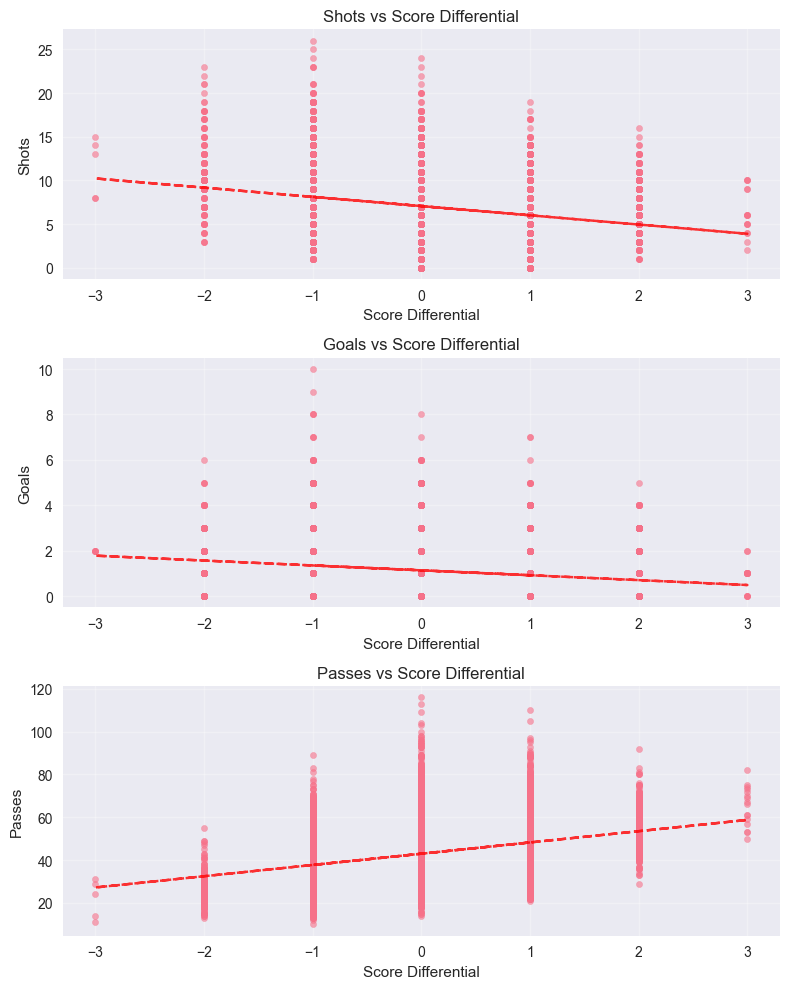

In [39]:
# ============================ 9.1 Backdoor path analysis ============================ #

    
# Visualize confounder effects
if len(OUTCOMES) < 4:
    fig, axes = plt.subplots(int(len(OUTCOMES)),1, figsize=(8, 10))
else:
    fig, axes = plt.subplots(int(np.ceil(len(OUTCOMES)/2)), 2, figsize=(15, 12))
axes = axes.ravel()

for i, outcome in enumerate(OUTCOMES):
    # Scatter plot with regression line
    axes[i].scatter(df["score_diff"], df[outcome], alpha=0.6, s=20)

    # Add regression line
    z = np.polyfit(df["score_diff"], df[outcome], 1)
    p = np.poly1d(z)
    axes[i].plot(df["score_diff"], p(df["score_diff"]), "r--", alpha=0.8)

    axes[i].set_xlabel("Score Differential")
    axes[i].set_ylabel(outcome.title())
    axes[i].set_title(f"{outcome.title()} vs Score Differential")
    axes[i].grid(True, alpha=0.3)

fig.tight_layout()
    